In [1]:
import networkx as nx
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
from copy import deepcopy 
import time



In [2]:
def euclidean_distance(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)


In [3]:
def read_graph(file_path):
    with open(file_path) as f:
        g = nx.Graph()
        for line in f:
            if not line[0].isdigit():
                continue
            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)
            g.add_node(node, x=x, y=y)
        
        for u in g.nodes:
            for v in range(u + 1, len(g.nodes)):
                g.add_edge(u, v,
                           distance=euclidean_distance(g.nodes[u]['x'],
                                                        g.nodes[u]['y'],
                                                        g.nodes[v]['x'],
                                                        g.nodes[v]['y']))
        return g

In [4]:
g = read_graph(file_path='wi29.tsp')
len(g.edges)

406

In [5]:
class Indivudal:
    def __init__(self, g):
        num_of_cities = len(g.nodes)
        self.code = np.random.permutation(num_of_cities).tolist()
        self.fitness = self.calc_fitness(g)
        
    def __lt__(self, other):
         return self.fitness < other.fitness
    
    def calc_fitness(self, g):
        dis = 0
        n = len(self.code)
        for i in range(n-1):
            dis += g[self.code[i]][self.code[i+1]]["distance"]
    
        dis += g[self.code[-1]][self.code[0]]["distance"]
        
        return dis

In [6]:
i = Indivudal(g)
i.fitness

110989.95499436805

In [7]:
def mutation(individual, mutation_prob):
    
    do = random.random() <= mutation_prob

    if do:
        n = len(individual.code)
        idx1 = random.randrange(n)
        #lista bez idx1
        allowed = list(set(range(n)).difference({idx1}))
        idx2 = random.choice(allowed)
        temp = individual.code[idx1]
        individual.code[idx1] = individual.code[idx2]
        individual.code[idx2] = temp
        

In [8]:
def selection(population, tournament_size,other_parent=None):
    allowed = list(set(range(len(population))).difference({other_parent}))
    chosen = random.sample(allowed, tournament_size)
    max_fitness = float('inf')
    winner_idx = None
    for idx in chosen:
        if max_fitness > population[idx].fitness:
            winner_idx = idx
            max_fitness = population[idx].fitness
    return winner_idx

In [9]:
def crossover(parent1, parent2,child1,child2):
    #ukrstanje prvog reda
    size = len(parent1.code)
    start, end = sorted(random.sample(range(size), 2))

    child1.code = [-1 for _ in range(size)]
    child2.code = [-1 for _ in range(size)]

    # Kopiraj segment između start i end iz roditelja
    child1.code[start:end] = parent1.code[start:end]
    child2.code[start:end] = parent2.code[start:end]

    # Indeksi za popunjavanje preostalih vrednosti
    idx1 = end % size
    idx2 = idx1

    # Popuni preostale vrednosti u detetu 1 s vrednostima iz drugog roditelja
    while idx1 != start:
        if parent2.code[idx2] not in child1.code:
            child1.code[idx1] = parent2.code[idx2]
            idx1 = (idx1 + 1) % size
        idx2 = (idx2 + 1) % size

    # Indeksi za popunjavanje preostalih vrednosti u detetu 2
    idx1 = end % size
    idx2 = idx1

    # Popuni preostale vrednosti u detetu 2 s vrednostima iz prvog roditelja
    while idx1 != start:
        if parent1.code[idx2] not in child2.code:
            child2.code[idx1] = parent1.code[idx2]
            idx1 = (idx1 + 1) % size
        idx2 = (idx2 + 1) % size

In [10]:
p1 = Indivudal(g)
p2 = Indivudal(g)
c1 = Indivudal(g)
c2 = Indivudal(g)

In [11]:
print(p1.code)
print(p2.code)

crossover(p1,p2,c1,c2)
print(c1.code)
print(c2.code)

[13, 15, 23, 25, 11, 5, 18, 4, 19, 10, 20, 14, 12, 3, 16, 2, 1, 22, 0, 26, 17, 8, 24, 21, 7, 27, 9, 28, 6]
[15, 14, 4, 2, 24, 6, 10, 8, 9, 1, 26, 28, 25, 17, 11, 0, 21, 18, 13, 23, 19, 16, 7, 12, 20, 5, 27, 22, 3]
[6, 10, 9, 28, 25, 11, 18, 13, 23, 19, 20, 14, 12, 3, 16, 2, 1, 22, 0, 26, 17, 8, 24, 21, 7, 5, 27, 15, 4]
[5, 4, 10, 14, 3, 2, 1, 22, 26, 8, 24, 28, 25, 17, 11, 0, 21, 18, 13, 23, 19, 16, 7, 12, 20, 27, 9, 6, 15]


In [12]:
def crossover1(parent1, parent2,child1,child2):
    
    n = len(parent1.code)
    child1_list = []
    child2_list = []
    
    breakpoint = random.randrange(n)
    
    child1_list.extend(parent1.code[:breakpoint])
    child2_list.extend(parent2.code[:breakpoint])
    
    for i in range(breakpoint,n):
        if parent2.code[i] not in child1_list:
            child1_list.append(parent2.code[i])
        if parent1.code[i] not in child2_list:
            child2_list.append(parent1.code[i])
        
    
    for node in parent2.code:
        if node not in child1_list:
            child1_list.append(node)
    for node in parent1.code:
        if node not in child2_list:
            child2_list.append(node)
            
    child1.code,child2.code = child1_list,child2_list

In [24]:
def simple_ga(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
            
        for i in range(elitism_size, pop_size, 2):
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    best_individual = min(population, key=lambda x: x.fitness)
    print("Best individual time:")
    print(best_individual.code)
    print(f"Fitness of best indvidual {best_individual.fitness}")
    print(1 / best_individual.fitness)
    
    return best_fitnesses

In [27]:
start = time.time()
best_fitnesses = simple_ga(g,1000,80,5,0.05,True,10,10)
end = time.time()
print(f"Execution time {end - start}s")

Best individual time:
[28, 20, 22, 21, 17, 11, 10, 9, 4, 3, 6, 2, 1, 0, 5, 7, 8, 12, 13, 16, 14, 18, 25, 24, 26, 23, 15, 19, 27]
Fitness of best indvidual 34889.28161031476
2.8662097751658985e-05
Execution time 2.5677802562713623s


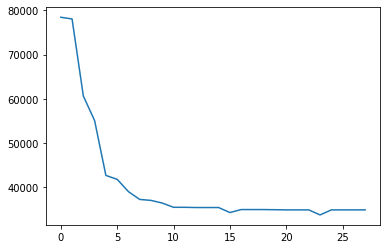

In [28]:
plt.plot([i for i in range(len(best_fitnesses))],best_fitnesses)